In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import pyOpenLPT as lpt
lpt.PythonStreamRedirector()

### Load camera parameters and images

In [2]:
ncam = 2
bit_depth = 16

# load cam 
cam = []
intensity_max = []
useid_list = []
for i in range(ncam):
    file = '../../test/inputs/test_BubbleRefImg/cam' + str(i+1) + '.txt'
    cam.append(lpt.math.Camera(file))
    intensity_max.append(2**bit_depth-1)
    useid_list.append(i)
cam_list = lpt.math.CamList(cam, intensity_max, useid_list)
print(cam_list.to_dict())

# load image path
imgio_list = []
folder = '../../test/inputs/test_BubbleRefImg/'
for i in range(ncam):
    file = 'cam' + str(i+1) + 'ImageNames.txt'
    imgio_list.append(lpt.math.ImageIO(folder, file))
    
# load bubble image
img_list = []
img_np_list = []
for i in range(ncam):
    img = imgio_list[i].loadImg(0)
    # invert image
    for i in range(img.getDimRow() * img.getDimCol()):
        img[i] = (2**16-1) - img[i]
    img_np = lpt.math.matrix_to_numpy(img)
    img_list.append(img)
    img_np_list.append(img_np)


{'cam_list': [<pyOpenLPT.math.Camera object at 0x000001EA7D6074B0>, <pyOpenLPT.math.Camera object at 0x000001EA7D6075F0>], 'intensity_max': [65535, 65535], 'useid_list': [0, 1]}


### Find 2D bubbles in each camera

cam 1 found 43 bubbles
cam 2 found 49 bubbles


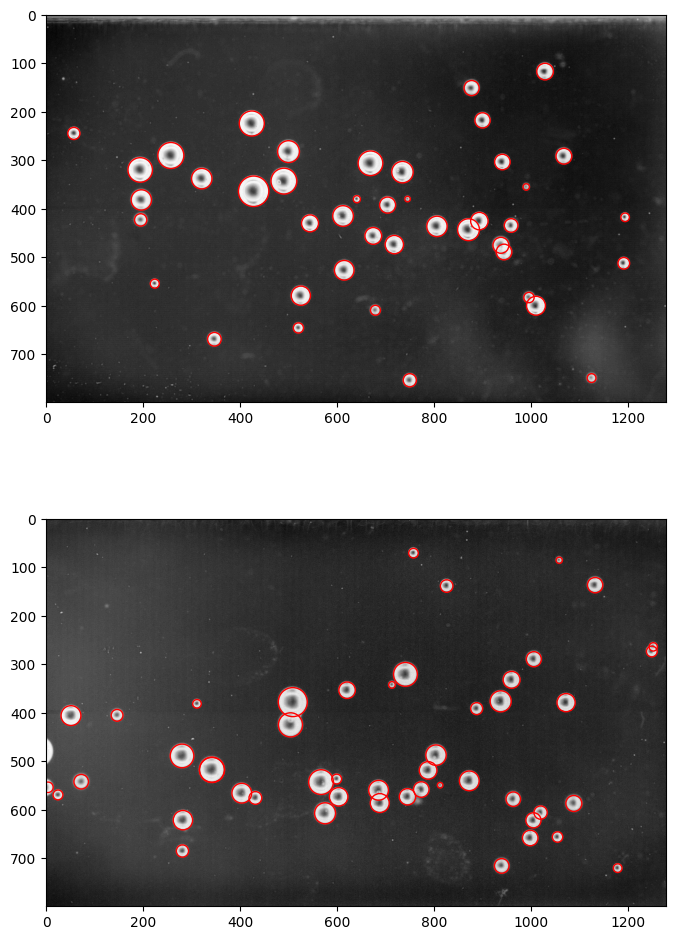

In [3]:
# define bubble property: [rmin,rmax,sensitivity]
bubble_property = [5, 50, 0.85]

bb2d_list_all = []
for i in range(ncam):
    bb2d_list = lpt.object.ObjectFinder2D().findBubble2D(img_list[i], bubble_property)
    bb2d_list_all.append(bb2d_list)
    print(f'cam {i+1} found {len(bb2d_list)} bubbles')

# plot
def draw_circle(ax, pt, r, color='red', linestyle='solid'):
    circle = plt.Circle((pt[0], pt[1]), r, linestyle=linestyle, color=color, fill=False)
    ax.add_artist(circle)
    
fig, axs = plt.subplots(ncam, 1, figsize=(8, 12))
for i in range(ncam):
    axs[i].imshow(img_np_list[i], cmap='gray')
    for bb2d in bb2d_list_all[i]:
        draw_circle(axs[i], bb2d._pt_center, bb2d._r_px, color='red')

### Bubble resize

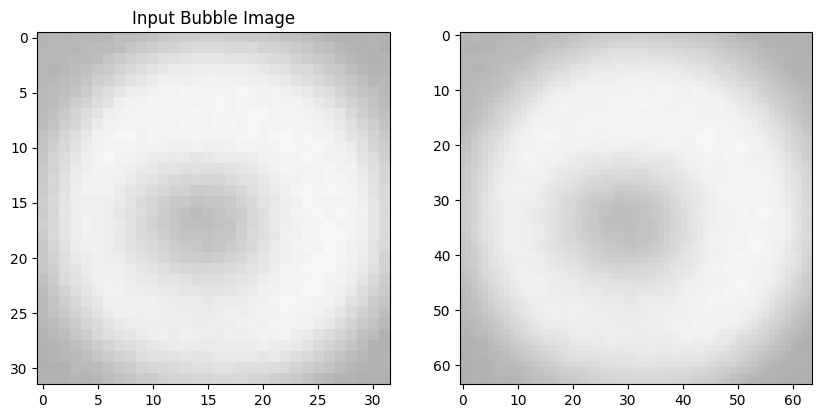

In [4]:
# test bubble resize 
cam_id = 0
bb2d = bb2d_list_all[cam_id][0]  # use the first bubble for resizing
row_min = int(np.floor(bb2d._pt_center[1] - bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + bb2d._r_px))
img_input_np = img_np_list[cam_id][row_min:row_max, col_min:col_max].copy() 
img_input = lpt.math.Image(lpt.math.numpy_to_matrix(img_input_np))

bb_resize = lpt.object.BubbleResize()
img_output = bb_resize.ResizeBubble(img_input, 64, 2**bit_depth-1)
img_output_np = lpt.math.matrix_to_numpy(img_output)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_input_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.title('Input Bubble Image')
plt.subplot(1, 2, 2)
plt.imshow(img_output_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)

### Stereomatch for bubbles

In [5]:
# stereo match
sm_param = lpt.stb.SMParam()
sm_param.tor_2d = 3.
# sm_param.tor_3d = 2.8e-2
sm_param.tor_3d = 5.0e-2
sm_param.n_thread = 6
sm_param.check_id = 2
sm_param.check_radius = 3
sm_param.is_delete_ghost = True
sm_param.is_update_inner_var = True

sm = lpt.stb.StereoMatch(sm_param, cam_list)
bb3d_list = sm.match(bb2d_list_all)
# sm.saveObjInfo(folder+'bb3d_list.csv', bb3d_list)
print('Number of 3D bubbles:', len(bb3d_list))


	Finish deleting gohst match: n_del = 9, n_after_del = 36.


Number of 3D bubbles: 36


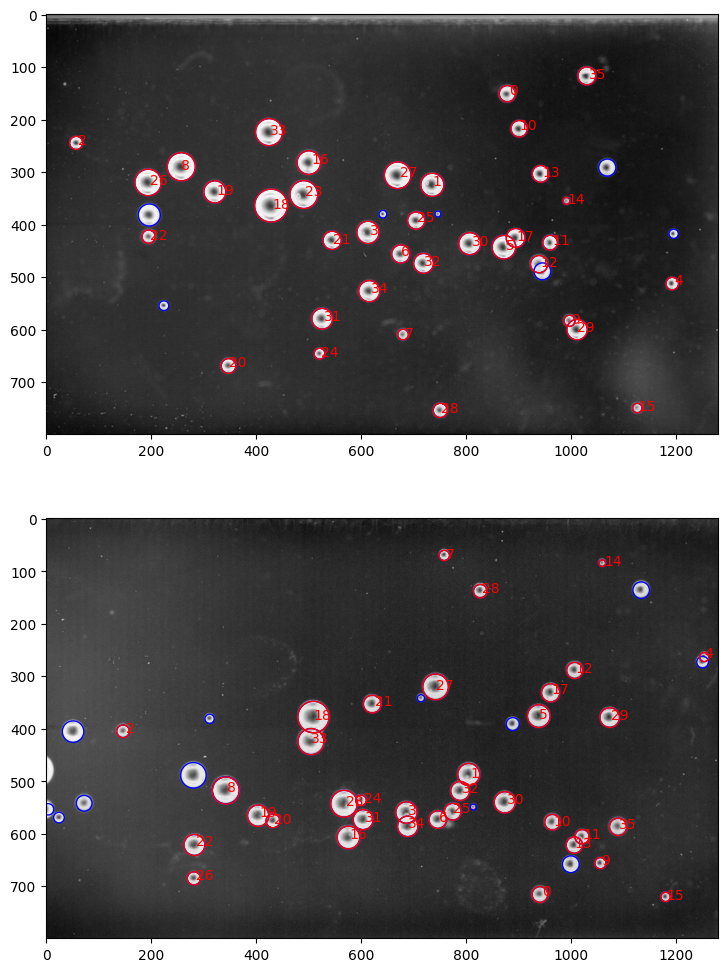

In [6]:
# plot 2d projection on each camera
fig, axs = plt.subplots(ncam, 1, figsize=(10, 12))
for cam_id in range(ncam):
    axs[cam_id].imshow(img_np_list[cam_id], cmap='gray')
    
    for bb2d in bb2d_list_all[cam_id]:
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='blue')
    
    for i in range(len(bb3d_list)):
        bb3d = bb3d_list[i]
        bb2d = bb3d._bb2d_list[cam_id]
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='red')
        axs[cam_id].text(bb2d._pt_center[0] + 5 * np.random.random(), bb2d._pt_center[1] + 5 * np.random.random(), str(i), color='red', alpha=1.0)


### Get bubble reference image

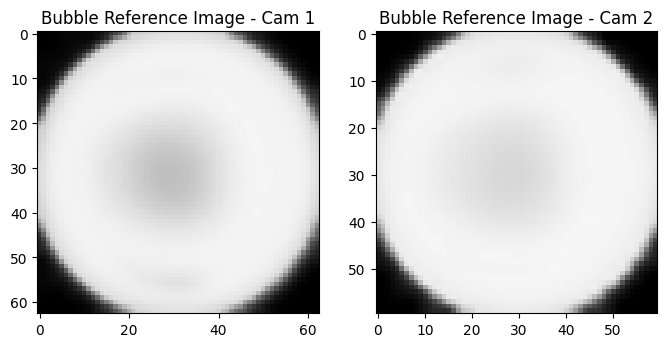

In [7]:
# get bubble reference image
bb_refimg = lpt.object.BubbleRefImg(cam_list)
is_valid, img_out = bb_refimg.GetBubbleRefImg(bb3d_list, bb2d_list_all, img_list)

fig, axs = plt.subplots(1, ncam, figsize=(8, 6))
for cam_id in range(ncam):
    img_out_np = lpt.math.matrix_to_numpy(img_out[cam_id])
    axs[cam_id].imshow(img_out_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
    axs[cam_id].set_title(f'Bubble Reference Image - Cam {cam_id + 1}')

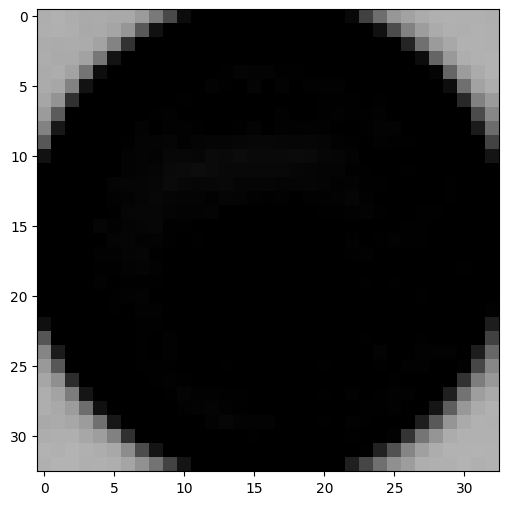

In [23]:
cam_id = 0
bb_id = 10 

# get bubble subimage
bb3d = bb3d_list[bb_id]
bb2d = bb3d._bb2d_list[cam_id]
row_min = int(np.floor(bb2d._pt_center[1] - bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + bb2d._r_px))
img_size = min(row_max - row_min, col_max - col_min)
img_np = img_np_list[cam_id][row_min:row_min+img_size, col_min:col_min+img_size].copy()
img = lpt.math.Image(lpt.math.numpy_to_matrix(img_np))

# resize ref image 
bb_resize = lpt.object.BubbleResize()
img_ref = bb_resize.ResizeBubble(img_out[cam_id], img_np.shape[0], 2**bit_depth-1)
img_ref_np = lpt.math.matrix_to_numpy(img_ref)

# residue img
img_res_np = img_np - img_ref_np
img_res_np[img_res_np < 0] = 0  # set negative values to 0

plt.figure(figsize=(8, 6))
# plt.imshow(img_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
# plt.imshow(img_ref_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.imshow(img_res_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)


cam 36 found 42 bubbles


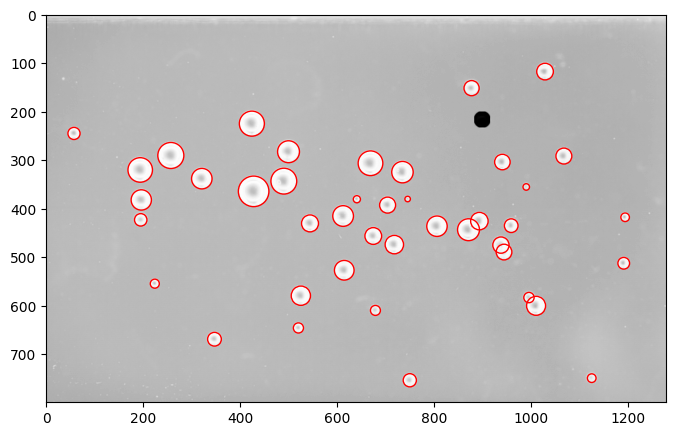

In [ ]:
# test if bubble reference image is fine
img_full_np = img_np_list[cam_id].copy()
img_full_np[row_min:row_min+img_size, col_min:col_min+img_size] = img_res_np
img_full = lpt.math.Image(lpt.math.numpy_to_matrix(img_full_np))

bubble_property = [5, 50, 0.85]
bb2d_list = lpt.object.ObjectFinder2D().findBubble2D(img_full, bubble_property)
print(f'cam {i+1} found {len(bb2d_list)} bubbles')

# plot
def draw_circle(ax, pt, r, color='red', linestyle='solid'):
    circle = plt.Circle((pt[0], pt[1]), r, linestyle=linestyle, color=color, fill=False)
    ax.add_artist(circle)

fig = plt.figure(figsize=(8, 6))
plt.imshow(img_full_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
for bb2d in bb2d_list:
    draw_circle(plt.gca(), bb2d._pt_center, bb2d._r_px, color='red')